In [1]:
import sys
sys.path.append('../torchuq_dev')
import torchuq
from torchuq.dataset.classification import get_classification_datasets

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from synthetic import *
device = torch.device('cpu')

In [3]:
train_dataset, _, _ = get_classification_datasets('adult', val_fraction=0.0, test_fraction=0.0)
data_loader = DataLoader(train_dataset, batch_size=32)


Loading dataset adult....
Splitting into train/val/test with 32561/0/0 samples
Done loading dataset adult


In [6]:
bx, by = iter(data_loader).next()
print(bx.shape, by.shape)
print(by)
x_dim = bx.shape[1] 

torch.Size([32, 105]) torch.Size([32])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


Epoch [1 / 50] average reconstruction error: 3142.500284


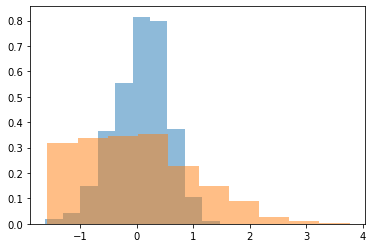

Epoch [11 / 50] average reconstruction error: 2382.682491


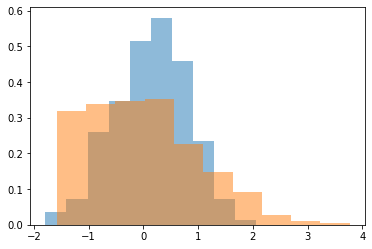

Epoch [21 / 50] average reconstruction error: 2211.344324


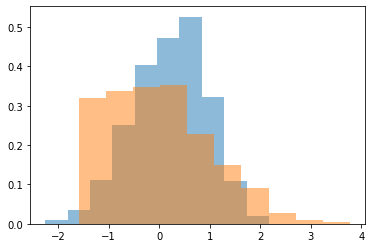

Epoch [31 / 50] average reconstruction error: 2129.293537


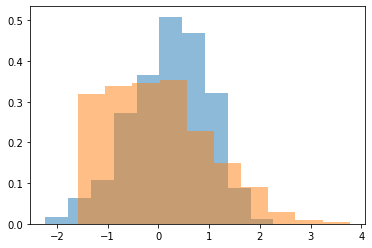

Epoch [41 / 50] average reconstruction error: 2086.241762


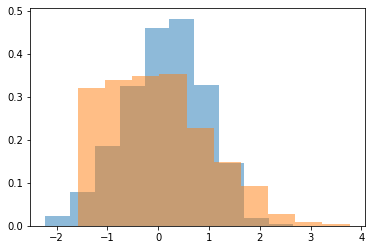

In [10]:
learning_rate = 0.001 # For optimizer (SGD or Adam)
weight_decay = 1e-5   # For optimizer (SGD or Adam)
epochs = 50          

from torch import optim 


def vae_loss(image, reconstruction, mu, logvar):
    """Loss for the Variational AutoEncoder."""
    # Binary Cross Entropy for batch
    BCE = (reconstruction - image).pow(2).sum()
    # Closed-form KL Divergence
    KLD = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE - KLD

# Instantiate VAE with Adam optimizer
vae = VAE(x_dim=x_dim)
vae = vae.to(device)    # send weights to GPU. Do this BEFORE defining Optimizer
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
vae.train()            # tell the network to be in training mode. Useful to activate Dropout layers & other stuff

# Train
losses = []

for epoch in range(epochs):
    # Store training losses & instantiate batch counter
    losses.append(0)
    number_of_batches = 0

    # Grab the batch, we are only interested in images not on their labels
    for images, _ in data_loader:
        # Save batch to GPU, remove existing gradients from previous iterations
        images = images.to(device)
        optimizer.zero_grad()

        # Feed images to VAE. Compute Loss.
        reconstructions, latent_mu, latent_logvar = vae(images)
        loss = vae_loss(images, reconstructions, latent_mu, latent_logvar)

        # Backpropagate the loss & perform optimization step with such gradients
        loss.backward()
        optimizer.step()

        # Add loss to the cumulative sum
        losses[-1] += loss.item()  
        number_of_batches += 1

    # Update average loss & Log information
    losses[-1] /= number_of_batches
    
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, epochs, losses[-1]))    

        new_samples = vae.generate(1000)

        from matplotlib import pyplot as plt
        plt.hist(new_samples[:, 0].detach().numpy(), density=True, alpha=0.5)
        plt.hist(train_dataset[:][0][:, 0].numpy(), density=True, alpha=0.5)
        plt.show()

In [11]:

import time
start_time = time.time() 

criterion = nn.CrossEntropyLoss()
net = NetworkFC(x_dim=x_dim).to(device)
optim = torch.optim.Adam(net.parameters(), lr=1e-3) 
for epoch in range(30):
    for bx, by in data_loader:
        bx = bx.to(device)
        by = by.to(device).to(torch.float32)
        optim.zero_grad()

        pred = net(bx)
        loss = pred.pow(2).mean() * 0.02
        loss += F.binary_cross_entropy(input=F.sigmoid(pred).flatten(), target=by)
        loss.backward()
        optim.step()
        
    print(loss)
    # print(((outcome0 - cur_pred) * (category * 2 - 1)).mean()

/sailhome/zhaosj12/.pyenv/versions/3.8.3/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.3297, grad_fn=<AddBackward0>)
tensor(0.3115, grad_fn=<AddBackward0>)
tensor(0.3044, grad_fn=<AddBackward0>)
tensor(0.3008, grad_fn=<AddBackward0>)
tensor(0.3003, grad_fn=<AddBackward0>)
tensor(0.3053, grad_fn=<AddBackward0>)
tensor(0.3112, grad_fn=<AddBackward0>)
tensor(0.3107, grad_fn=<AddBackward0>)
tensor(0.3064, grad_fn=<AddBackward0>)
tensor(0.3090, grad_fn=<AddBackward0>)
tensor(0.3030, grad_fn=<AddBackward0>)
tensor(0.2917, grad_fn=<AddBackward0>)
tensor(0.2835, grad_fn=<AddBackward0>)
tensor(0.2772, grad_fn=<AddBackward0>)
tensor(0.2767, grad_fn=<AddBackward0>)
tensor(0.2740, grad_fn=<AddBackward0>)
tensor(0.2769, grad_fn=<AddBackward0>)
tensor(0.2746, grad_fn=<AddBackward0>)
tensor(0.2758, grad_fn=<AddBackward0>)
tensor(0.2742, grad_fn=<AddBackward0>)
tensor(0.2726, grad_fn=<AddBackward0>)
tensor(0.2672, grad_fn=<AddBackward0>)
tensor(0.2688, grad_fn=<AddBackward0>)
tensor(0.2657, grad_fn=<AddBackward0>)
tensor(0.2668, grad_fn=<AddBackward0>)
tensor(0.2643, grad_fn=<A

In [12]:
synthetic_data = SyntheticDataset(vae, net)

In [13]:
import pickle 
torch.save(synthetic_data, 'dataset_adult.pt')


In [14]:
dataset = torch.load('dataset_adult.pt')
dataset.generate(10)

(tensor([[-0.1324, -0.3808, -0.8429,  ...,  0.8480,  0.6150,  0.0953],
         [ 0.6711, -0.3060, -0.8855,  ...,  0.4919, -0.4209, -0.0529],
         [-0.0854, -0.1276, -1.0294,  ...,  0.2574, -0.8516, -0.4783],
         ...,
         [ 1.0326, -0.0447,  0.2515,  ...,  0.0147,  0.4344, -1.2067],
         [ 0.5746, -0.5387, -0.8358,  ...,  0.6220,  2.4062,  2.9809],
         [ 0.6406,  0.1547, -0.6701,  ...,  0.8733, -0.2799,  0.2455]]),
 tensor([[0.1376],
         [0.1010],
         [0.1117],
         [0.2706],
         [0.3934],
         [0.4058],
         [0.0767],
         [0.7599],
         [0.0722],
         [0.3959]]))